In [1]:
from config import settings
import os

os.environ["LANGSMITH_TRACING"] = str(settings.LANGSMITH_TRACING)
os.environ["LANGSMITH_API_KEY"] = settings.LANGSMITH_API_KEY
os.environ["OPENAI_API_KEY"] = settings.OPENAI_API_KEY

In [2]:
# Pricing (approximate for gpt-4o-mini)
MODEL_PRICING = {
    "gpt-4o-mini": {"input": 0.15 / 1_000_000, "output": 0.60 / 1_000_000},
    "text-embedding-3-small": {"input": 0.02 / 1_000_000, "output": 0}
}

### Caching & Cost Tracking Utilities

In [3]:
import hashlib

# Simple In-Memory Cache
llm_cache = {}

def get_cache_key(prompt, model_name):
    """Generates a unique hash for the prompt and model."""
    raw_key = f"{model_name}::{prompt}"
    return hashlib.sha256(raw_key.encode()).hexdigest()

def calculate_cost(usage, model_name):
    """Calculates cost based on token usage."""
    if not usage:
        return 0.0
    
    input_tokens = usage.get('prompt_tokens', 0)
    output_tokens = usage.get('completion_tokens', 0)
    
    prices = MODEL_PRICING.get(model_name, {"input": 0, "output": 0})
    cost = (input_tokens * prices["input"]) + (output_tokens * prices["output"])
    return cost

### Setup LLM & Optimizations (Query Rewriting + Reranking)

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Main LLM
llm_model_name = "gpt-4o-mini"
llm = ChatOpenAI(model=llm_model_name, temperature=0)

# --- Optimization 1: Query Rewriting ---
# Rewrites user queries to be more specific for retrieval
rewrite_system_prompt = """You are a helpful assistant that generates multiple search queries based on a single input query. 
Rewrite the following query to be more specific and optimized for a vector search engine regarding Python programming.
Return ONLY the rewritten query text, nothing else."""

rewrite_chain = (
    ChatPromptTemplate.from_messages([("system", rewrite_system_prompt), ("human", "{question}")])
    | llm
    | StrOutputParser()
)

# --- Optimization 2: Reranking ---
# We will use a lightweight local reranker (FlashRank)
from langchain_classic.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.document_compressors import FlashrankRerank

compressor = FlashrankRerank(model="ms-marco-MiniLM-L-12-v2")

print("Optimization tools initialized.")

INFO:flashrank.Ranker:Downloading ms-marco-MiniLM-L-12-v2...
ms-marco-MiniLM-L-12-v2.zip: 100%|██████████| 21.6M/21.6M [00:04<00:00, 5.15MiB/s]


Optimization tools initialized.


### Vector DB (Milvus) & Contextual Retrieval

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_milvus import Milvus

THINKPYTHON_CHAPTERS = [
    "https://allendowney.github.io/ThinkPython/chap01.html",
    "https://allendowney.github.io/ThinkPython/chap02.html",
    "https://allendowney.github.io/ThinkPython/chap03.html",
]

def load_and_index_docs():
    bs4_strainer = bs4.SoupStrainer(name=("h1", "h2", "h3", "p", "pre", "code"))

    loader = WebBaseLoader(
        web_paths=THINKPYTHON_CHAPTERS,
        bs_kwargs={"parse_only": bs4_strainer},
    )
    docs = loader.load()

    # --- Contextual Retrieval Strategy ---
    # Prepend the source/title to the content so chunking doesn't lose context
    for d in docs:
        d.page_content = f"Source: {d.metadata.get('source', 'ThinkPython')}\nTopic: Python Basics\n\n{d.page_content}"

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        add_start_index=True,
    )
    splits = splitter.split_documents(docs)
    
    # Setup Embeddings
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

    # --- Using Milvus Lite (Local File) ---
    # This creates a local file 'milvus_demo.db' instead of needing a server
    vector_store = Milvus.from_documents(
        splits,
        embeddings,
        connection_args={"uri": "./milvus_demo.db"},
        collection_name="python_docs",
        drop_old=True  # Reset DB for this run
    )
    
    return vector_store

In [ ]:
# Initialize Vector DB
vector_store = load_and_index_docs()

# Setup Base Retriever
base_retriever = vector_store.as_retriever(search_kwargs={"k": 10})

# Setup Reranking Retriever (Retrieves 10 -> Reranks -> Returns Top 5)
rerank_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, 
    base_retriever=base_retriever
)

print("Milvus Vector Store and Reranker ready.")

/home/abinet/tiger/rag/.venv/lib/python3.13/site-packages/milvus_lite/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Milvus Vector Store and Reranker ready.


In [12]:
base_retriever.invoke("What is a function in Python?")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(metadata={'pk': 463390774563962929, 'source': 'https://allendowney.github.io/ThinkPython/chap03.html', 'start_index': 84}, page_content='Think PythonFront MatterChaptersEnd MatterFunctions Contents You can order print and ebook versions of Think Python 3e from\nBookshop.org and\nAmazon.3. Functions#In the previous chapter we used several functions provided by Python, like int and float, and a few provided by the math module, like sqrt and pow.\nIn this chapter, you will learn how to create your own functions and run them.\nAnd we’ll see how one function can call another.\nAs examples, we’ll display lyrics from Monty Python songs.\nThese silly examples demonstrate an important feature – the ability to write your own functions is the foundation of programming.This chapter also introduces a new statement, the for loop, which is used to repeat a computation.3.1. Defining new functions#A function definition specifies the name of a new function and the sequence of statements that r

In [13]:
rerank_retriever.invoke("What is a function in Python?")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(metadata={'id': 0, 'relevance_score': np.float32(0.99109286), 'pk': 463390774563962929, 'source': 'https://allendowney.github.io/ThinkPython/chap03.html', 'start_index': 84}, page_content='Think PythonFront MatterChaptersEnd MatterFunctions Contents You can order print and ebook versions of Think Python 3e from\nBookshop.org and\nAmazon.3. Functions#In the previous chapter we used several functions provided by Python, like int and float, and a few provided by the math module, like sqrt and pow.\nIn this chapter, you will learn how to create your own functions and run them.\nAnd we’ll see how one function can call another.\nAs examples, we’ll display lyrics from Monty Python songs.\nThese silly examples demonstrate an important feature – the ability to write your own functions is the foundation of programming.This chapter also introduces a new statement, the for loop, which is used to repeat a computation.3.1. Defining new functions#A function definition specifies the name of 

### Optimized RAG Chain (The "Core" Logic)
Includes: Cache Check -> Rewrite -> Retrieve -> Rerank -> Generate with Citations -> Cost Calc

In [15]:
import time
import json
from uuid import uuid4
import traceback

def optimized_rag_chain(query, use_cache=True):
    start_time = time.time()
    log = {
        "id": str(uuid4()), 
        "query": query, 
        "cache_hit": False, 
        "steps": {}
    }

    # 1. Caching
    cache_key = get_cache_key(query, llm_model_name)
    if use_cache and cache_key in llm_cache:
        print(f"⚡ Cache Hit for query: '{query}'")
        log["cache_hit"] = True
        log["latency"] = time.time() - start_time
        return llm_cache[cache_key], log

    try:
        # 2. Query Rewriting
        rewritten_query = rewrite_chain.invoke(query)
        log["steps"]["rewritten_query"] = rewritten_query
        
        # 3. Retrieval + Reranking
        # We retrieve based on the *rewritten* query
        docs = rerank_retriever.invoke(rewritten_query)
        
        # 4. Context Preparation with Citations Support
        # We ensure metadata is available for the LLM to cite
        context_parts = []
        for i, d in enumerate(docs):
            source = d.metadata.get('source', 'Unknown')
            content = d.page_content.replace("\n", " ")
            context_parts.append(f"[{i+1}] Source: {source}\nContent: {content}")
        
        context_str = "\n\n".join(context_parts)
        log["steps"]["retrieved_context"] = context_str

        # 5. Generation
        system_prompt = """
        You are a Python tutor. Answer the question based ONLY on the provided context.
        
        CRITICAL INSTRUCTION: CITATIONS
        You MUST cite your sources. Every time you state a fact from the context, 
        reference the source number like [1], [2] etc.
        At the end of your answer, list the full source URLs used.
        """
        
        messages = [
            ("system", system_prompt),
            ("human", f"Context:\n{context_str}\n\nQuestion: {query}")
        ]
        
        response = llm.invoke(messages)
        answer = response.content
        
        # 6. Cost Calculation
        token_usage = response.response_metadata.get("token_usage", {})
        cost = calculate_cost(token_usage, llm_model_name)
        
        log["answer"] = answer
        log["cost_usd"] = cost
        log["token_usage"] = token_usage

        # Store in Cache
        llm_cache[cache_key] = (answer, context_str)

    except Exception as e:
        log["error"] = str(e)
        log["traceback"] = traceback.format_exc()
        return ("Sorry, I encountered an error.", ""), log

    log["latency"] = time.time() - start_time
    
    # Log to file
    with open("logs/optimized_rag_logs.jsonl", "a") as f:
        f.write(json.dumps(log) + "\n")

    return (answer, context_str), log

#### Demonstration: Cache Hits & Citations

In [16]:
print("--- Request 1: Cold Start ---")
(ans1, ctx1), log1 = optimized_rag_chain("How do I define a function in Python?")
print(f"Latency: {log1['latency']:.4f}s | Cost: ${log1.get('cost_usd', 0):.6f}")
print("Answer Snippet:", ans1[:150])
print("\n")

--- Request 1: Cold Start ---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Latency: 7.0390s | Cost: $0.000197
Answer Snippet: To define a function in Python, you use the `def` keyword followed by the function name and parentheses. Inside the parentheses, you can specify any p




In [17]:
print("--- Request 2: Identical Query (Cache Hit) ---")
(ans2, ctx2), log2 = optimized_rag_chain("How do I define a function in Python?")
print(f"Latency: {log2['latency']:.4f}s")
print("Answer Match:", ans1 == ans2)

--- Request 2: Identical Query (Cache Hit) ---
⚡ Cache Hit for query: 'How do I define a function in Python?'
Latency: 0.0006s
Answer Match: True


In [19]:
print("Context:", ctx1)
print("Answer:", ans1)

Context: [1] Source: https://allendowney.github.io/ThinkPython/chap03.html
Content: Think PythonFront MatterChaptersEnd MatterFunctions Contents You can order print and ebook versions of Think Python 3e from Bookshop.org and Amazon.3. Functions#In the previous chapter we used several functions provided by Python, like int and float, and a few provided by the math module, like sqrt and pow. In this chapter, you will learn how to create your own functions and run them. And we’ll see how one function can call another. As examples, we’ll display lyrics from Monty Python songs. These silly examples demonstrate an important feature – the ability to write your own functions is the foundation of programming.This chapter also introduces a new statement, the for loop, which is used to repeat a computation.3.1. Defining new functions#A function definition specifies the name of a new function and the sequence of statements that run when the function is called. Here’s an example:def print_lyrics():

### Automated Evaluation (Ragas) on Optimized Chain

- Load previously generated synthetic queries (from Module 1 logic)
- Note: Ensure 'datasets/synthetic_queries_with_gt.csv' exists from previous steps

In [20]:
import pandas as pd

try:
    test_df = pd.read_csv("datasets/synthetic_queries_with_gt.csv")
except FileNotFoundError:
    print("Synthetic dataset not found. Please run the generation step from Module 1 code.")
    test_df = pd.DataFrame()

if not test_df.empty:
    results = []
    
    print(f"Evaluating {len(test_df)} queries...")
    
    for _, row in test_df.iterrows():
        (answer, context), log = optimized_rag_chain(row["query"], use_cache=False) # Disable cache for eval
        
        results.append({
            "user_input": row["query"],
            "response": answer,
            "retrieved_contexts": [context],
            "reference": row["ground_truth"],
            "latency": log["latency"],
            "cost": log.get("cost_usd", 0)
        })

    eval_df = pd.DataFrame(results)
    
    eval_df.to_csv("logs/optimized_rag_evaluation_results.csv", index=False)
    print("Evaluation results saved to 'logs/optimized_rag_evaluation_results.csv'.")

    eval_df.head()

Evaluating 36 queries...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request

Evaluation results saved to 'logs/optimized_rag_evaluation_results.csv'.


### RAGAS Evaluation

In [21]:
# Run Ragas Metrics
if not test_df.empty:
    from ragas import evaluate
    from ragas.metrics import AnswerRelevancy, Faithfulness, ContextPrecision, ContextRecall
    from datasets import Dataset
    from ragas.llms.base import llm_factory
    from ragas.embeddings.base import embedding_factory
    from openai import AsyncOpenAI
    
    openai_client = AsyncOpenAI()
    ragas_embeddings = embedding_factory(provider="openai", model="text-embedding-3-small", client=openai_client)
    ragas_llm = llm_factory("gpt-4o-mini", client=openai_client)

    rag_dataset = Dataset.from_pandas(eval_df)
    
    scores = evaluate(
        dataset=rag_dataset,
        metrics=[AnswerRelevancy(), Faithfulness(), ContextPrecision(), ContextRecall()],
        llm=ragas_llm,
        embeddings=ragas_embeddings,
        raise_exceptions=False
    )
    
    final_scores = scores.to_pandas()
    final_scores.to_csv("datasets/optimized_rag_evaluation.csv", index=False)
    print("\nEvaluation Complete. Average Scores:")
    print(final_scores[["faithfulness", "answer_relevancy", "context_precision", "context_recall"]].mean())

/home/abinet/tiger/rag/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_15145/2118419195.py:4: DeprecationWarning: Importing AnswerRelevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import AnswerRelevancy
  from ragas.metrics import AnswerRelevancy, Faithfulness, ContextPrecision, ContextRecall
/tmp/ipykernel_15145/2118419195.py:4: DeprecationWarning: Importing Faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import Faithfulness
  from ragas.metrics import AnswerRelevancy, Faithfulness, ContextPrecision, ContextRecall
/tmp/ipykernel_15145/2118419195.py:4: Depre


Evaluation Complete. Average Scores:
faithfulness         0.689571
answer_relevancy          NaN
context_precision    0.166667
context_recall       0.087963
dtype: float64


Total Cost of Evaluation Run: $0.006957
Average Cost per Query: $0.000193


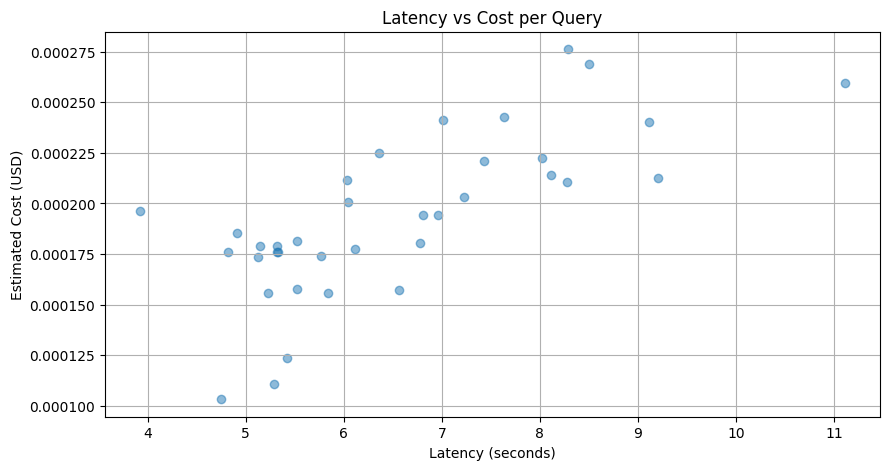

In [24]:
if not test_df.empty:
    import matplotlib.pyplot as plt
    
    avg_cost = eval_df['cost'].mean()
    total_cost = eval_df['cost'].sum()
    
    print(f"Total Cost of Evaluation Run: ${total_cost:.6f}")
    print(f"Average Cost per Query: ${avg_cost:.6f}")
    
    # Plot Latency vs Cost
    plt.figure(figsize=(10, 5))
    plt.scatter(eval_df['latency'], eval_df['cost'], alpha=0.5)
    plt.title("Latency vs Cost per Query")
    plt.xlabel("Latency (seconds)")
    plt.ylabel("Estimated Cost (USD)")
    plt.grid(True)
    plt.show()